In [4]:
#have to install pandas_ta fist
!pip install pandas_ta

#import required libraries
#######################################################################################
#THESE LIBRARIES ARE FOR INITIAL DATA PREPARATION
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from datetime import datetime, timedelta
#FOR SCALING THE DATA
from sklearn.preprocessing import MinMaxScaler
import joblib
#FOR TRAINING THE LSTM MODEL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#set random seed for reproducibility
np.random.seed(42)
########################################################################################

######------THIS FUNCTION IS FOR GETTING 10 YEARS OF STOCK DATA----------#############
def get_ticker_data(ticker):
  START_DATE = '2014-08-01'
  END_DATE = datetime.now().strftime('%Y-%m-%d')
  #Download stock data
  try:
    data = yf.download(TICKER, start=START_DATE, end=END_DATE)

    #check if data is empty
    if data.empty:
      raise ValueError(f"No data found for {TICKER} from {START_DATE} to {END_DATE}")

    #display first ten rows of the data
    print(data.tail(10))

    #display basic stats:
    print("\nBasic Statistics:")
    print(data.describe())
    print("Dataset length:", len(data))

    #plot closing prices
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data['Close'])
    plt.title(f'{TICKER} Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.show()

    return data, START_DATE, END_DATE

  except Exception as e:
    print(f"Error: {e}")


#############--------------ADDING INDICATOR SET-----------------###############
def add_indicators(data, indicator_set='default'):
  """
  Add technical indicators to the dataset.

  Args:
  data (pd.DataFrame): Input dataframe with OHLCV data
  indicator_set(str): 'default' or 'alternative'

  Returns:
  pd.DataFrame: Dataframe with added indicators
  """

  if indicator_set == 'default':
    #default indicator set
    data['RSI'] = ta.rsi(data.Close, length = 15)
    data['EMAF'] = ta.ema(data.Close, length = 20)
    data['EMAM'] = ta.ema(data.Close, length = 100)
    data['EMAS'] = ta.ema(data.Close, length = 150)


  elif indicator_set == 'alternative':
    #alternate indicator set
    bb = ta.bbands(data.Close, length = 20)
    data = pd.concat([data, bb], axis = 1)
    data['EMA'] = ta.ema(data.Close, length = 50)
    data['VWAP'] = ta.vwap(data.High, data.Low, data.Close, data.Volume)

  else:
    raise ValueError("Invalid indicator set. Use 'default' or 'alternative'.")

  return data

###########-------------CREATE TARGET COLUMN-------------------################
def prepare_target(data):
  """
  Prepare target variables for the LSTM model

  Args:
  data (pd.DataFrame): Input dataframe with OHLCV data

  Returns:
  pd.DataFrame: Dataframe with target variables
  """
  # Next day's price movement
  data['Target'] = data['Adj Close'] - data.Open
  data['Target'] = data['Target'].shift(-1)

  #Binary classification target
  data['TargetClass'] = (data['Target'] > 0).astype(int)

  #next day's closing price
  data['TargetNextClose'] = data['Adj Close'].shift(-1)

  return data

###########-------DROP UNNECESSARY COLUMNS, RESET INDEX--------------###########
def clean_data(data, columns_to_drop = ['Volume', 'Close', 'Date']):
  """
  Clean the dataset by dropping NaN values and specified columns

  Args:
  data (pd.DataFrame): Input dataframe
  columns_to_drop (list): List of columns to drop

  Returns:
  pd.DataFrame: Cleaned dataframe
  """
  data.dropna(inplace = True)
  print('CLEANING dropna: dataset length: ', len(data))

  data.reset_index(inplace = True)
  print('CLEANING rst idx: dataset length: ', len(data))

  data.drop(columns_to_drop, axis = 1, inplace = True)
  print('CLEANING drop col: dataset length: ', len(data))


  return data


#############----------SCALE DATA TO RANGE OF 0 TO 1-----------------################
def scale_data(data, feature_range = (0,1), save_scaler = True, scaler_path = 'scaler.pkl'):
  """
  Prepare the dataset by handling non-numeric columns first

  Scale the dataset using MinMaxScaler

  Args:
  data (pd.DataFrame or np.array): Input data to be scaled
  feature_range (tuple): Range to scale the data to (default: (0,1))
  save_scaler (bool): Whether to save the scaler object (default: True)
  scaler_path (str): Path to save the scaler object (default: 'scaler.pkl)

  Returns:
  np.array: Scaled Dataset
  MinMaxScaler: Fitted Scaler Object
  """

  numeric_columns = data.select_dtypes(include = [np.number]).columns
  non_numeric_columns = data.select_dtypes(exclude = [np.number]).columns

  if len(non_numeric_columns) > 0:
    print(f"Non-numeric columns found: {non_numeric_columns}")
    print("These columns will be dropped for scaling.")

  #select only numeric columns for scaling
  data_numeric = data[numeric_columns]

  #initialize MinMaxScaler
  scaler = MinMaxScaler(feature_range = feature_range)

  """
  #check if input is a dataframe, if so, convert to np array
  if isinstance(data, pd.DataFrame):
    data_array = data.values
  else:
    data_array = data
  """

  #fit and transform the data
  data_scaled = scaler.fit_transform(data)

  #save the scaler for later use (like inverse scaling)
  if save_scaler:
    joblib.dump(scaler, scaler_path)
    print(f"Scaler saved to {scaler_path}")

  return data_scaled, scaler


##########----------------PREPARE LSTM DATA------------------#####################
def prepare_lstm_data(data_set_scaled, backcandles = 30, target_column = -1, feature_columns = None):

  """
  Prepare data for LSTM model by creating sequences of historical data.

  Args:
  data_set_scaled (np.array): Scaled input data
  backcandles (int): Number of historical time steps to use for each sample
  target_column (int): Index of the target column (-1 for last column)
  feature_columns (list): Number of columns to use as features (N)

  Returns:
  tuple: X (input sequences), y (target values)
  """

  X = []
  print(data_set_scaled.shape[0])
  for j in feature_columns:
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
      X[j].append(data_set_scaled[i-backcandles:i, j])

  #Move axis from 0 to position 2
  X = np.moveaxis(X, [0], [2])
  #Extract target values
  y = data_set_scaled[backcandles:, target_column]

  return np.array(X), np.array(y).reshape(-1,1)



##############------------TRAIN LSTM----------------------######################
def create_and_train_lstm(X_train, y_train, backcandles = 30, features = 9, lstm_units = 150, batch_size = 15, epochs = 30, validation_split = 0.1, patience = 15):
  """
  Creates and trains lstm model

  Args:
  X_train(np.ndarray): Training input data with shape (samples, backcandles, features)
  y_train(np.ndarray): training target data
  backcandles(int): Number of time steps to look back (default = 30)
  features(int): Number of input features (default = 9)
  lstm_units(int): Number of units in LSTM layer (default = 150)
  batch_size(int): Batch size for training (default = 15)
  epochs(int): Number of epochs for training (default = 30)
  validation_split(float): fraction of training data to use for validation (default = 0.1)

  Returns:
  keras.Model: trained LSTM keras model

  """
  np.random.seed(42)
  tf.random.set_seed(42)

  lstm_input = layers.Input(shape=(backcandles, features), name='lstm_input')
  inputs = layers.LSTM(lstm_units, name='first_layer')(lstm_input)
  inputs = layers.Dense(1, name='dense_layer')(inputs)
  #inputs = layers.Dropout(0.005)(inputs) #Dropout for regulation
  output = layers.Activation('linear', name='output')(inputs)
  model = models.Model(inputs=lstm_input, outputs=output)
  adam = optimizers.Adam(learning_rate = 0.001)
  model.compile(optimizer=adam, loss='mse')

  early_stopping = EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights = True)
  model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only = True, monitor = 'val_loss')

  history = model.fit(
      x=X_train,
      y=y_train,
      batch_size=batch_size,
      epochs=epochs,
      shuffle=True,
      validation_split = validation_split,
      callbacks = [early_stopping, model_checkpoint])

  model.summary()

  return model, history

In [ ]:
price_check = yf.download('NVDA', start='2022-10-12', end='2022-10-13')
print(price_check)

[*********************100%***********************]  1 of 1 completed

              Open    High     Low  Close  Adj Close     Volume
Date                                                           
2022-10-12  11.579  11.735  11.345   11.5  11.490477  492590000


#PREPARE DATA

[*********************100%***********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-27  125.050003  129.199997  123.879997  128.300003  128.300003   
2024-08-28  128.119995  128.330002  122.639999  125.610001  125.610001   
2024-08-29  121.360001  124.430000  116.709999  117.589996  117.589996   
2024-08-30  119.529999  121.750000  117.220001  119.370003  119.370003   
2024-09-03  116.010002  116.209999  107.290001  108.000000  108.000000   
2024-09-04  105.410004  113.269997  104.120003  106.209999  106.209999   
2024-09-05  104.989998  109.650002  104.760002  107.209999  107.209999   
2024-09-06  108.040001  108.150002  100.949997  102.830002  102.830002   
2024-09-09  104.879997  106.550003  103.690002  106.470001  106.470001   
2024-09-10  107.809998  109.400002  104.949997  108.099998  108.099998   

               Volume  
Date                   
2024-08-27  303134600  
2024-08-28  448101100  
2024-08-29  453

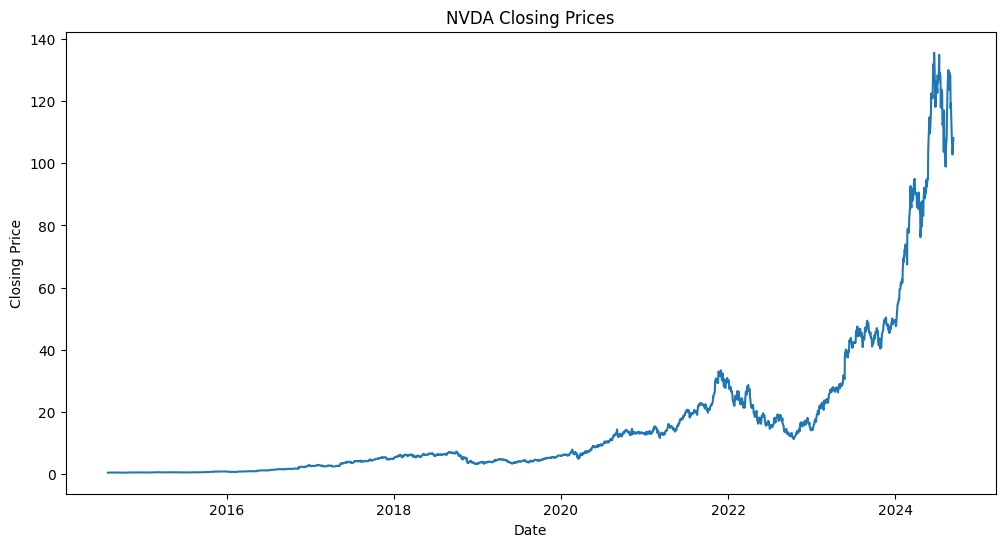

dataset length:  2544
dataset length:  2544
dataset length:  2544
CLEANING dropna: dataset length:  2394
CLEANING rst idx: dataset length:  2394
CLEANING drop col: dataset length:  2394
dataset length:  2394
            Open        High         Low   Adj Close        RSI        EMAF  \
2374  106.320000  111.070000  106.260002  109.019997  46.710928  111.012683   
2375  112.440002  116.230003  111.580002  116.139999  52.386989  111.500999   
2376  118.529999  118.599998  114.070000  118.080002  53.822879  112.127571   
2377  118.760002  123.239998  117.470001  122.860001  57.228081  113.149707   
2378  121.940002  125.000000  121.180000  124.580002  58.410480  114.238306   
2379  124.279999  130.000000  123.419998  130.000000  61.960822  115.739420   
2380  128.399994  129.880005  125.889999  127.250000  59.212930  116.835666   
2381  127.320000  129.350006  126.660004  128.500000  60.075244  117.946555   
2382  130.020004  130.750000  123.099998  123.739998  55.304728  118.498311   
23

In [5]:
#Get ticker data:
#Define stock ticker and date range
TICKER = 'NVDA'
data, START_DATE, END_DATE = get_ticker_data(TICKER)

#main execution of the last three cells:
indicator_set = 'default'
#indicator_set = 'alternative'
print('dataset length: ', len(data))

data = add_indicators(data, indicator_set)
print('dataset length: ', len(data))

data = prepare_target(data)
print('dataset length: ', len(data))

data = clean_data(data)

print('dataset length: ', len(data))
print(data.tail(20))

print(data.columns)

print('--------------------------------------------------------------------')


#Scale the data
feature_range = (0,1) #adjustable
save_scaler = True #adjustable
scaler_path = 'lstm_scaler.pkl' #adjustable

data_set_scaled, scaler = scale_data(data, feature_range, save_scaler, scaler_path)

print("Scaled data shape:", data_set_scaled.shape)
print("\nFirst few rows of scaled data:")
print(data_set_scaled[:5])

print("\n Scaling ranges:")
for i, column in enumerate(data.columns):
  print(f"{column}: {data_set_scaled[:,i].min():.4f} to {data_set_scaled[:,i].max():.4f}")

print(data.columns)

#TRAIN LSTM

In [6]:
#DEFINE VARIABLES
#scaler usage
backcandles = 30 #also used for training function
target_column = -1 #last column
feature_columns = [0,1,2,3,4,5,6,7,8]
#Training Usage
features = len(feature_columns)
lstm_units = 150
batch_size = 15
epochs = 300
validation_split = 0.1
patience = 20
#Prepare data
X, y = prepare_lstm_data(data_set_scaled, backcandles, target_column, feature_columns)

print("Input shape (X):", X.shape)
print("Target shape (y):", y.shape)

print("\nSample input sequence:")
print(X[0])
print("\nCorresponding target value:")
print(y[0])
print('\n-----------------------------------------------------------------------------\n')
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

print('\n-----------------------------------------------------------------------------\n')
#TRAIN THE MODEL
model, history = create_and_train_lstm(X_train, y_train, backcandles, features, lstm_units, batch_size, epochs, validation_split, patience)

2394
Input shape (X): (2364, 30, 9)
Target shape (y): (2364, 1)

Sample input sequence:
[[6.24467349e-04 5.89926310e-04 6.51797819e-04 5.61912701e-04
  6.09287549e-01 3.98242229e-04 0.00000000e+00 0.00000000e+00
  5.16992675e-01]
 [5.93961836e-04 5.79233131e-04 6.48008119e-04 5.72613632e-04
  6.17597572e-01 4.11053655e-04 1.01153497e-05 9.43276866e-06
  5.17317080e-01]
 [6.20878289e-04 6.45176456e-04 6.78324360e-04 6.42169464e-04
  6.69302942e-01 4.30042704e-04 2.18010509e-05 2.00235387e-05
  5.16734571e-01]
 [6.72917306e-04 6.71910041e-04 7.06745977e-04 6.20768925e-04
  6.40629167e-01 4.44947070e-04 3.27105426e-05 3.00792888e-05
  5.16932132e-01]
 [6.11906281e-04 5.88144184e-04 5.96849661e-04 5.83315445e-04
  5.91229536e-01 4.54448540e-04 4.24505690e-05 3.93110327e-05
  5.17117249e-01]
 [5.93961836e-04 5.75668454e-04 5.98744285e-04 5.88665690e-04
  5.95900204e-01 4.63614169e-04 5.21339286e-05 4.85191900e-05
  5.17031440e-01]
 [6.51384230e-04 6.38047528e-04 6.89693007e-04 6.36818778e-0

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

In [7]:
y_predict = model.predict(X_test)
print('test size:', len(y_predict))
#for i in range(len(y_predict)):
  #  print(y_predict[i], y_test[i])

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
test size: 473


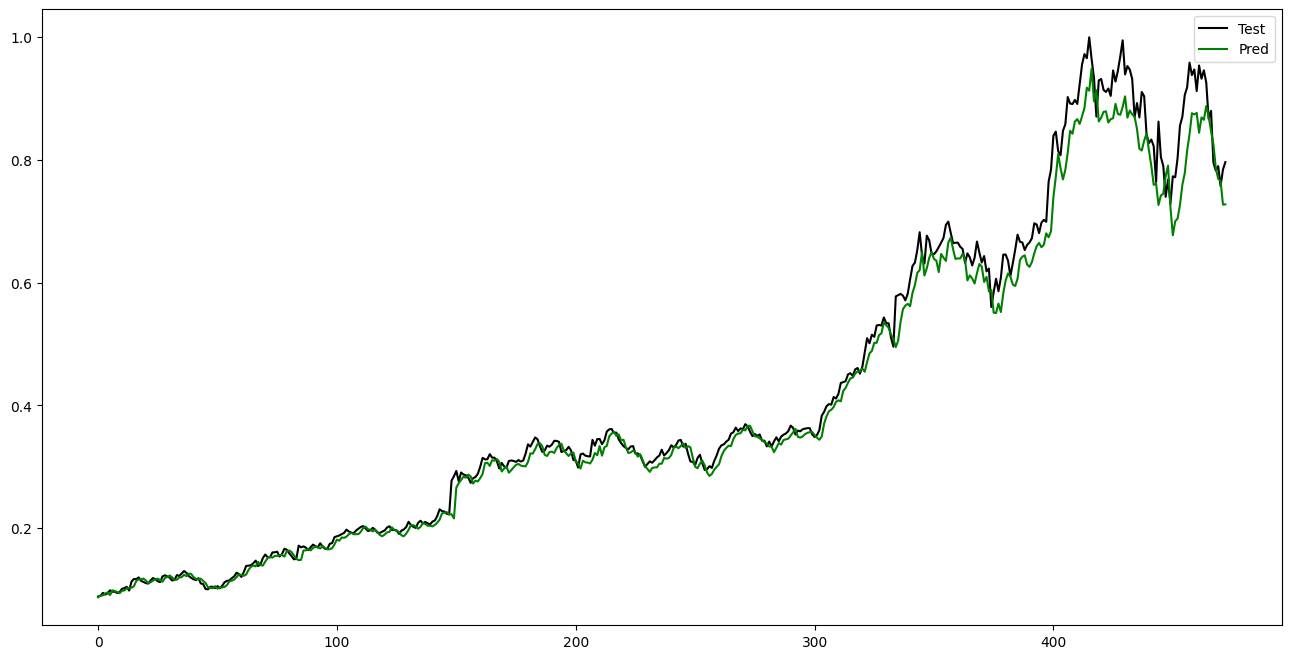

In [8]:
plt.figure(figsize = (16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_predict, color = 'green', label = 'Pred')
plt.legend()
plt.show()

In [ ]:
#---------------------------------------------------------------------------
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
#---------------------------------------------------------------------------

def inverse_transform_predictions(scaler, scaled_predictions, feature_index):
  """
  Inverses transform the scaled predictions back to original scale

  Args:
  scaler (MinMaxScaler): The fitted scaler object
  scaled_predictions (np.array): The scaled predictions
  feature_index (int): The index of the feature to inverse transform

  Returns:
  np.array: The inverse transformed predictions

  """

  #Create a dummy array with the same shape as the training data
  dummy_array = np.zeros((len(scaled_predictions), scaler.n_features_in_))

  #put the predictions into the correct column
  dummy_array[:, feature_index] = scaled_predictions.flatten()

  #inverse transform
  return scaler.inverse_transform(dummy_array)[:, feature_index]

# Function to get the next trading day
def next_trading_day(date, holidays):
    next_day = date + pd.Timedelta(days=1)
    while next_day.weekday() >= 5 or next_day in holidays:
        next_day += pd.Timedelta(days=1)
    return next_day



# Update the next_day variable in the get_price_predictions function
def get_price_predictions(model, X_test, scaler, original_data, backcandles, target_column_index):
    """
    Get price predictions with corresponding dates.

    Args:
    model (keras.Model): The trained LSTM model
    X_test (np.array): The test input data
    scaler (MinMaxScaler): The fitted scaler object
    original_data (pd.DataFrame): The original dataframe with dates
    backcandles (int): The number of historical candles used for each prediction
    target_column_index (int): The index of the target column in the original dataset

    Returns:
    pd.DataFrame: A dataframe with dates and predicted prices
    """
    # Make predictions
    y_predict_scaled = model.predict(X_test)

    # Inverse transform predictions
    y_predict = inverse_transform_predictions(scaler, y_predict_scaled, target_column_index)

    # Get the dates for the test set
    test_dates = original_data.index[-len(X_test):]

    # Create a dataframe with dates and predictions
    predictions_df = pd.DataFrame({
        'Date': test_dates,
        'Predicted Price': y_predict.flatten(),
        'Actual Price': original_data['Adj Close'].values[-len(X_test):]
    })

    # Predict the next day
    last_sequence = X_test[-1:].reshape(1,backcandles, -1)
    next_day_scaled = model.predict(last_sequence)
    next_day_price = inverse_transform_predictions(scaler, next_day_scaled, target_column_index)

    #get next trading day
    # Create a holiday calendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=data.index.min(), end=data.index.max())
    # Adjust the next day prediction to handle weekends and holidays
    last_date = data.index[-1]
    next_trading_date = next_trading_day(last_date, holidays)

    # Add the next day prediction
    next_day_prediction = pd.DataFrame({
        'Date': [next_trading_date],
        'Predicted Price': next_day_price.flatten(),
        'Actual Price': [np.nan] #placeholder for unknown actual price
    })

    # Concatenate the predictions with the next day prediction
    predictions_df = pd.concat([predictions_df, next_day_prediction])

    return predictions_df



#----------------------------------------------------------------------------------
# Load the original data again
data = yf.download(TICKER, start=START_DATE, end=END_DATE)
print("original dataset length:", len(data))
print(data.tail(5))

#remove rows with Nan values but keep the last row
data_cleaned = data.dropna().iloc[:-1]
last_row = data.iloc[-1:]
data_cleaned = pd.concat([data_cleaned, last_row])

print("Cleaned dataset length:", len(data_cleaned))
print(data_cleaned.tail(10))

# Load the saved scaler
scaler = joblib.load('lstm_scaler.pkl')

# Get price predictions
predictions_df = get_price_predictions(model, X_test, scaler, data, backcandles, target_column_index=-1)

# Print the first few predictions
print('FIRST FEW PREDICTIONS')
print(predictions_df.head())
print('\nLAST FEW PREDICTIONS WITH NEXT DAY')
# Print the last few predictions
print(predictions_df.tail())

[*********************100%***********************]  1 of 1 completed

original dataset length: 2543
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-03  116.010002  116.209999  107.290001  108.000000  108.000000   
2024-09-04  105.410004  113.269997  104.120003  106.209999  106.209999   
2024-09-05  104.989998  109.650002  104.760002  107.209999  107.209999   
2024-09-06  108.040001  108.150002  100.949997  102.830002  102.830002   
2024-09-09  104.879997  106.550003  103.690002  106.470001  106.470001   

               Volume  
Date                   
2024-09-03  477155100  
2024-09-04  372470300  
2024-09-05  306850700  
2024-09-06  413638100  
2024-09-09  273912000  
Cleaned dataset length: 2543
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-26  129.570007  131.259995  124.370003  126.459999  126.459999   
2024-08-27  125.050003  129.1999

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
FIRST FEW PREDICTIONS
        Date  Predicted Price  Actual Price
0 2022-10-20        12.229552     12.183904
1 2022-10-21        12.323604     12.455676
2 2022-10-24        12.735189     12.588567
3 2022-10-25        12.715430     13.250018
4 2022-10-26        13.140426     12.885321

LAST FEW PREDICTIONS WITH NEXT DAY
          Date  Predicted Price  Actual Price
469 2024-09-04       106.800445    106.209999
470 2024-09-05       105.029501    107.209999
471 2024-09-06       105.018009    102.830002
472 2024-09-09        98.869071    106.470001
0   2024-09-10        98.869071           NaN


In [ ]:
#---------------------------------------------------------------------------
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
#---------------------------------------------------------------------------

def inverse_transform_predictions(scaler, scaled_predictions, feature_index):
  """
  Inverses transform the scaled predictions back to original scale

  Args:
  scaler (MinMaxScaler): The fitted scaler object
  scaled_predictions (np.array): The scaled predictions
  feature_index (int): The index of the feature to inverse transform

  Returns:
  np.array: The inverse transformed predictions

  """

  #Create a dummy array with the same shape as the training data
  dummy_array = np.zeros((len(scaled_predictions), scaler.n_features_in_))

  #put the predictions into the correct column
  dummy_array[:, feature_index] = scaled_predictions.flatten()

  #inverse transform
  return scaler.inverse_transform(dummy_array)[:, feature_index]


# Load the original data again
data = yf.download(TICKER, start=START_DATE, end=END_DATE)
print("original dataset length:", len(data))
print(data.tail(5))



#------------------------------------------------------------------------------------

# Create a holiday calendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=data.index.min(), end=data.index.max())

# Function to get the next trading day
def next_trading_day(date, holidays):
    next_day = date + pd.Timedelta(days=1)
    while next_day.weekday() >= 5 or next_day in holidays:
        next_day += pd.Timedelta(days=1)
    return next_day

# Adjust the next day prediction to handle weekends and holidays
last_date = data.index[-1]
next_trading_date = next_trading_day(last_date, holidays)

# Update the next_day variable in the get_price_predictions function
def get_price_predictions(model, X_test, scaler, original_data, backcandles, target_column_index):
    """
    Get price predictions with corresponding dates.

    Args:
    model (keras.Model): The trained LSTM model
    X_test (np.array): The test input data
    scaler (MinMaxScaler): The fitted scaler object
    original_data (pd.DataFrame): The original dataframe with dates
    backcandles (int): The number of historical candles used for each prediction
    target_column_index (int): The index of the target column in the original dataset

    Returns:
    pd.DataFrame: A dataframe with dates and predicted prices
    """
    # Make predictions
    y_predict_scaled = model.predict(X_test)

    # Inverse transform predictions
    y_predict = inverse_transform_predictions(scaler, y_predict_scaled, target_column_index)

    # Get the dates for the test set
    test_dates = original_data.index[-len(X_test):]

    # Create a dataframe with dates and predictions
    predictions_df = pd.DataFrame({
        'Date': test_dates,
        'Predicted Price': y_predict
    })

    # Predict the next day
    last_sequence = X_test[-1:]
    next_day_scaled = model.predict(last_sequence)
    next_day_price = inverse_transform_predictions(scaler, next_day_scaled, target_column_index)

    # Add the next day prediction
    next_day_prediction = pd.DataFrame({
        'Date': [next_trading_date],
        'Predicted Price': next_day_price
    })

    # Concatenate the predictions with the next day prediction
    predictions_df = pd.concat([predictions_df, next_day_prediction])

    return predictions_df



#-----------------------------------------------------------------------------------
#remove rows with Nan values but keep the last row
data_cleaned = data.dropna().iloc[:-1]
last_row = data.iloc[-1:]
data_cleaned = pd.concat([data_cleaned, last_row])

print("Cleaned dataset length:", len(data_cleaned))
print(data_cleaned.tail(10))

# Load the saved scaler
scaler = joblib.load('lstm_scaler.pkl')

# Get price predictions
predictions_df = get_price_predictions(model, X_test, scaler, data, backcandles, target_column_index=-1)

# Print the first few predictions
print(predictions_df.head())

# Print the last few predictions
print(predictions_df.tail())

[*********************100%***********************]  1 of 1 completed

original dataset length: 2543
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-03  116.010002  116.209999  107.290001  108.000000  108.000000   
2024-09-04  105.410004  113.269997  104.120003  106.209999  106.209999   
2024-09-05  104.989998  109.650002  104.760002  107.209999  107.209999   
2024-09-06  108.040001  108.150002  100.949997  102.830002  102.830002   
2024-09-09  104.879997  106.550003  103.690002  106.470001  106.470001   

               Volume  
Date                   
2024-09-03  477155100  
2024-09-04  372470300  
2024-09-05  306850700  
2024-09-06  413638100  
2024-09-09  273912000  
Cleaned dataset length: 2543
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-26  129.570007  131.259995  124.370003  126.459999  126.459999   
2024-08-27  125.050003  129.1999

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
        Date  Predicted Price
0 2022-10-20        12.229552
1 2022-10-21        12.323604
2 2022-10-24        12.735189
3 2022-10-25        12.715430
4 2022-10-26        13.140426
          Date  Predicted Price
469 2024-09-04       106.800445
470 2024-09-05       105.029501
471 2024-09-06       105.018009
472 2024-09-09        98.869071
0   2024-09-10        98.869071


#Here I am going to add some cells for evaluating the training history and overall performance.

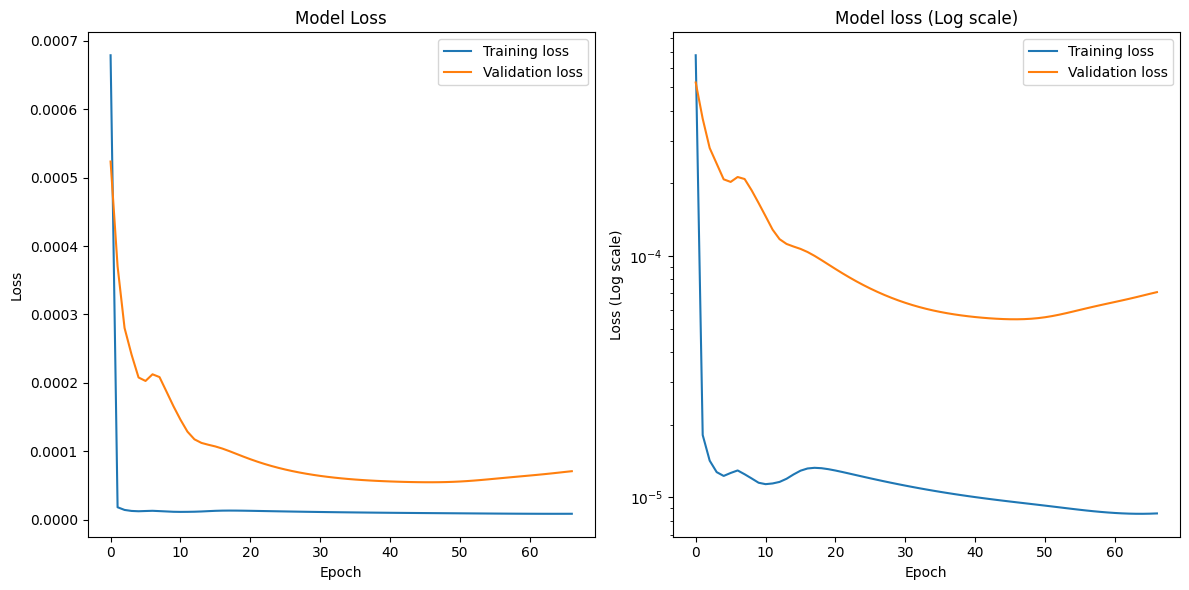

In [ ]:
def plot_training_history(history):
  plt.figure(figsize = (12,6))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], label = 'Training loss')
  plt.plot(history.history['val_loss'], label = 'Validation loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label = 'Training loss')
  plt.plot(history.history['val_loss'], label = 'Validation loss')
  plt.title('Model loss (Log scale)')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (Log scale)')
  plt.yscale('log')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_training_history(history)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred, set_name=""):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print(f"{set_name} Metrics:")
  print(f"MSE: {mse:.4f}")
  print(f"RMSE: {rmse:.4f}")
  print(f"MAE: {mae:.4f}")
  print(f"R^2 score: {r2:.4f}\n")

#metrics for training set
y_train_pred = model.predict(X_train)
calculate_metrics(y_train, y_train_pred, "Training")
#metrics for test set:
y_test_pred = model.predict(X_test)
calculate_metrics(y_test, y_test_pred, "Test")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Training Metrics:
MSE: 0.0000
RMSE: 0.0035
MAE: 0.0023
R^2 score: 0.9960

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test Metrics:
MSE: 0.0004
RMSE: 0.0211
MAE: 0.0129
R^2 score: 0.9933



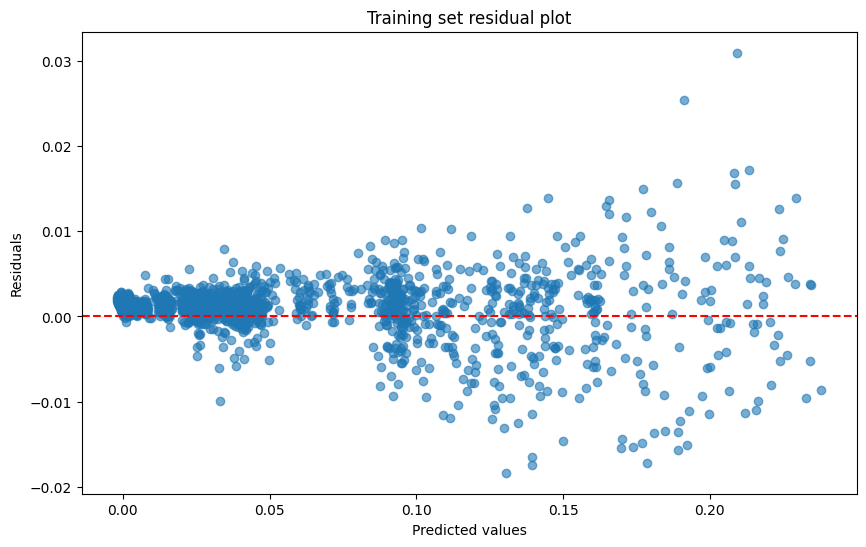

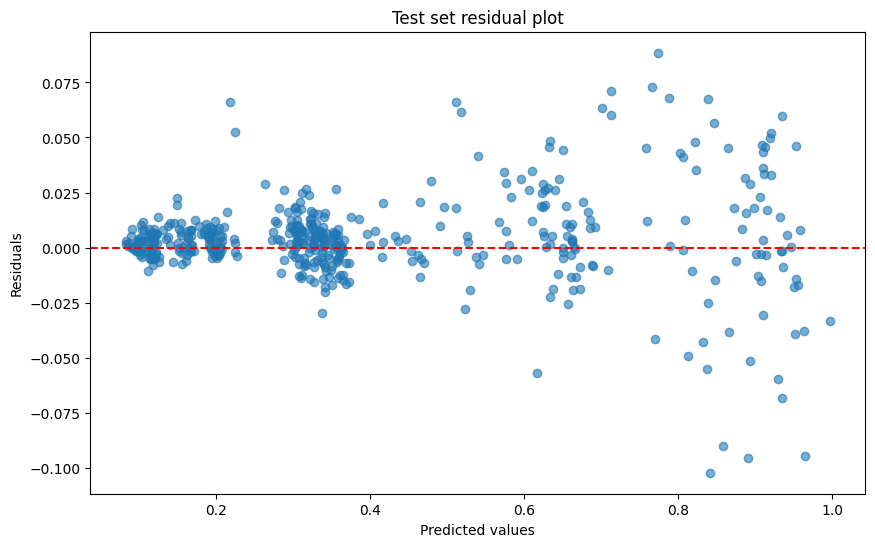

In [ ]:
#function for residual plot:
def plot_residuals(y_true, y_pred, title = "Residual Plot"):
  residuals = y_true - y_pred
  plt.figure(figsize = (10, 6))
  plt.scatter(y_pred, residuals, alpha = 0.6)
  plt.title(title)
  plt.xlabel('Predicted values')
  plt.ylabel('Residuals')
  plt.axhline(y = 0, color = 'r', linestyle = '--')
  plt.show()

plot_residuals(y_train, y_train_pred, "Training set residual plot")
plot_residuals(y_test, y_test_pred, 'Test set residual plot')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


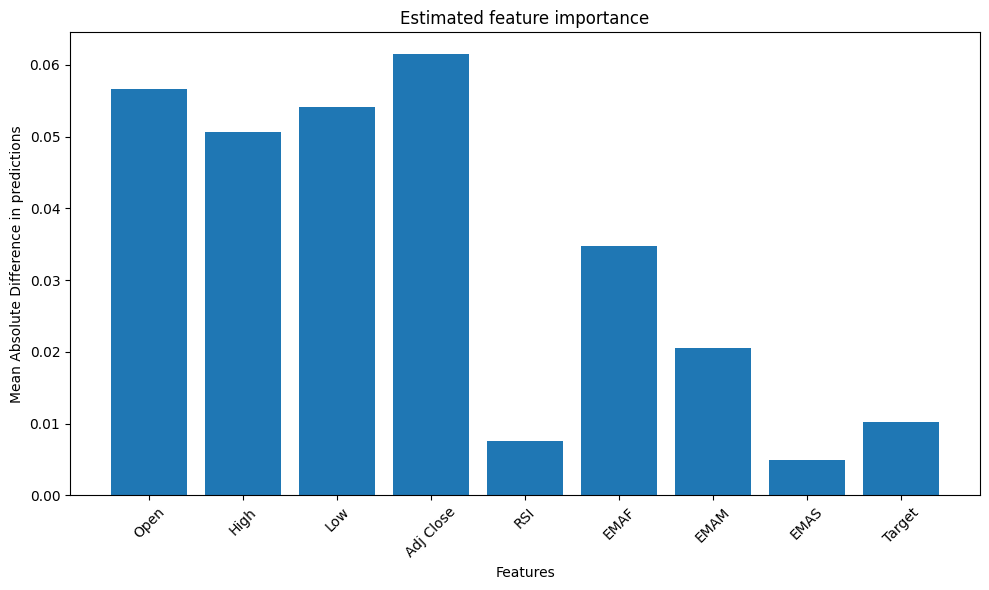

In [ ]:
#estimating feature importance:
def estimate_feature_importance(model, X, feature_names):
  baseline_pred = model.predict(X)
  importance = []

  for i in range(X.shape[2]):
    X_permuted = X.copy()
    X_permuted[:,:,i] = np.random.permutation(X_permuted[:,:,i])
    permuted_pred = model.predict(X_permuted)
    importance.append(np.mean(np.abs(baseline_pred - permuted_pred)))

  plt.figure(figsize = (10,6))
  plt.bar(feature_names, importance)
  plt.title('Estimated feature importance')
  plt.xlabel('Features')
  plt.ylabel('Mean Absolute Difference in predictions')
  plt.xticks(rotation = 45)
  plt.tight_layout()
  plt.show()

feature_names = ['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'Target']
estimate_feature_importance(model, X_test, feature_names)

#This is a rolling window approach that will evaluate the performance across different training sizes. It should give a better idea of how it will perform when predicting out of sample data.

Epoch 1/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0025 - val_loss: 5.2429e-04
Epoch 2/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.1321e-04 - val_loss: 9.6626e-07
Epoch 3/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.4600e-05 - val_loss: 9.9815e-06
Epoch 4/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.0148e-06 - val_loss: 1.4055e-05
Epoch 5/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.6571e-06 - val_loss: 1.4996e-05
Epoch 6/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.6450e-06 - val_loss: 1.8793e-05
Epoch 7/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.2693e-06 - val_loss: 1.9235e-05
Epoch 8/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.6140e-06 - val_loss: 1.4364e-05
Epoch 9/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.0915e-06 - val_loss: 1.0839e-05
Epoch 10/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 8.8835e-07 - val_loss: 8.5233e-06
Epoch 11/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0012 - val_loss: 1.3251e-05
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.5168e-05 - val_loss: 1.9368e-05
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.0476e-06 - val_loss: 1.2937e-05
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.0829e-06 - val_loss: 1.2438e-05
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.4571e-06 - val_loss: 1.0026e-05
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 2.0504e-06 - val_loss: 6.6882e-06
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.8349e-06 - val_loss: 4.9718e-06
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.6011e-06 - val_loss: 4.4993e-06
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.5343e-06 - val_loss: 3.6161e-06
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.5353e-06 - val_loss: 3.1107e-06
Epoch 11/300
48/48 ━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Epoch 1/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0014 - val_loss: 3.1654e-06
Epoch 2/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 6.2366e-06 - val_loss: 1.6758e-06
Epoch 3/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 4.9194e-06 - val_loss: 1.4591e-06
Epoch 4/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 4.0783e-06 - val_loss: 1.1839e-06
Epoch 5/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.7676e-06 - val_loss: 1.1904e-06
Epoch 6/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.7619e-06 - val_loss: 1.5612e-06
Epoch 7/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.2217e-06 - val_loss: 1.3446e-06
Epoch 8/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.8929e-06 - val_loss: 1.6533e-06
Epoch 9/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 4.8823e-06 - val_loss: 2.5878e-06
Epoch 10/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 4.1240e-06 - val_loss: 3.4541e-06
Epoch 11/300
71/71 ━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 1/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0015 - val_loss: 3.5867e-05
Epoch 2/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 9.1341e-06 - val_loss: 2.9583e-05
Epoch 3/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.7558e-06 - val_loss: 2.7541e-05
Epoch 4/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 5.2461e-06 - val_loss: 3.0020e-05
Epoch 5/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 4.2964e-06 - val_loss: 3.0121e-05
Epoch 6/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.0381e-06 - val_loss: 2.3591e-05
Epoch 7/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 4.1763e-06 - val_loss: 2.2291e-05
Epoch 8/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 4.1982e-06 - val_loss: 2.2240e-05
Epoch 9/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 4.4523e-06 - val_loss: 2.0883e-05
Epoch 10/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 5.1061e-06 - val_loss: 2.1981e-05
Epoch 11/300
95/95 ━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Epoch 1/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0020 - val_loss: 1.5373e-04
Epoch 2/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 3.7061e-05 - val_loss: 1.0361e-04
Epoch 3/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 2.7215e-05 - val_loss: 7.4838e-05
Epoch 4/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 2.2731e-05 - val_loss: 6.7273e-05
Epoch 5/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 2.0717e-05 - val_loss: 6.4718e-05
Epoch 6/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 1.9229e-05 - val_loss: 6.2432e-05
Epoch 7/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.8213e-05 - val_loss: 6.7059e-05
Epoch 8/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 1.8769e-05 - val_loss: 7.2432e-05
Epoch 9/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 1.9605e-05 - val_loss: 7.4756e-05
Epoch 10/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.9779e-05 - val_loss: 7.9090e-05
Epo

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


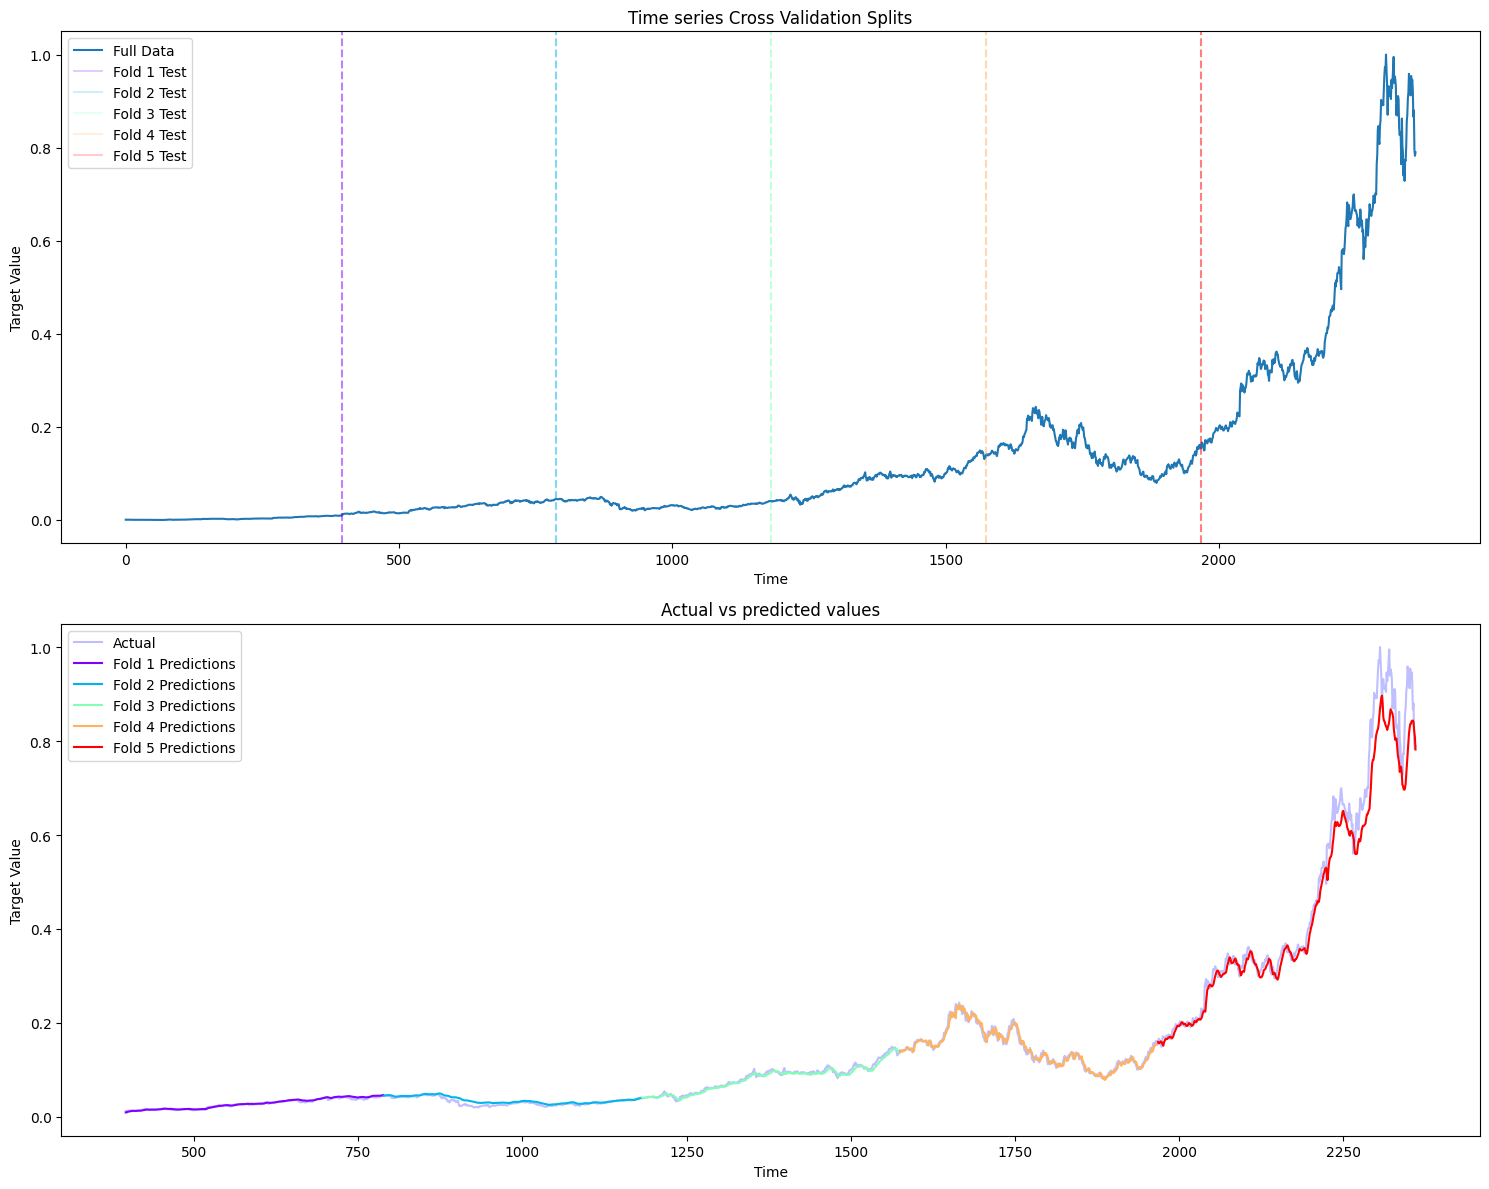

MSE - Mean: 0.0005, Std: 0.0009
RMSE - Mean: 0.0132, Std: 0.0175
MAE - Mean: 0.0090, Std: 0.0111
R2 - Mean: 0.9005, Std: 0.1334


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def time_series_cv_lstm(X, y, n_splits = 5, backcandles = 30, features = 9, lstm_units = 150, batch_size = 15, epochs = 30):
  tscv = TimeSeriesSplit(n_splits = n_splits)

  cv_scores = {
      'mse': [],
      'rmse': [],
      'mae': [],
      'r2': []
  }

  #prepare plots
  fig, (ax1,ax2) = plt.subplots(2,1,figsize = (15,12))
  colors =  plt.cm.rainbow(np.linspace(0,1, n_splits))

  #plot data and splits
  ax1.plot(range(len(y)), y, label='Full Data')
  ax1.set_title('Time series Cross Validation Splits')
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Target Value')

  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #plot splits
    ax1.axvline(x=train_index[-1], color = colors[fold], linestyle = '--', alpha = 0.5)
    ax1.axvline(train_index[-1], test_index[-1], alpha=0.2, color = colors[fold], label = f'Fold {fold+1} Test')

    #reset and recreate the model for each fold
    tf.keras.backend.clear_session()
    model, history = create_and_train_lstm(X_train, y_train, backcandles, features, lstm_units, batch_size, epochs)

    #make predictions
    y_pred = model.predict(X_test)

    #Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    #Store scores:
    cv_scores['mse'].append(mse)
    cv_scores['rmse'].append(rmse)
    cv_scores['mae'].append(mae)
    cv_scores['r2'].append(r2)

    #plot predictions
    ax2.plot(test_index, y_test, color = 'blue', alpha = 0.25, label = 'Actual' if fold == 0 else '')
    ax2.plot(test_index, y_pred, color = colors[fold], label = f'Fold {fold+1} Predictions')

  ax1.legend(loc = 'upper left')
  ax2.set_title('Actual vs predicted values')
  ax2.set_xlabel('Time')
  ax2.set_ylabel('Target Value')
  ax2.legend()
  plt.tight_layout()
  plt.show()

  #calculate mean and std scores:
  for metric in cv_scores:
    print(f'{metric.upper()} - Mean: {np.mean(cv_scores[metric]):.4f}, Std: {np.std(cv_scores[metric]):.4f}')

  return cv_scores, fig
#define n_splits, use all other previous hyperparamters
n_splits = 5
cv_scores, fig = time_series_cv_lstm(X,y,n_splits=5, backcandles=backcandles, features=features, lstm_units=lstm_units, batch_size=batch_size, epochs=epochs)

#Below is some additional cells for trying to get an actual price prediction. I will return to these once I get a better idea of how the training and base predictions are going

#random code and tests

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, sc):
    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform predictions and actual values if they were scaled
    if sc is not None:
        y_pred = sc.inverse_transform(y_pred)
        y_test = sc.inverse_transform(y_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared Score: {r2:.4f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(12, 6))
    plt.scatter(y_pred, residuals)
    plt.title('Residuals vs Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

print("Model Performance:")
evaluate_model(model, X_test, y_test, scaler)



# Compare training histories
plt.figure(figsize=(12, 6))
plt.plot(original_history.history['loss'], label='Original Training Loss')
plt.plot(original_history.history['val_loss'], label='Original Validation Loss')
plt.plot(updated_history.history['loss'], label='Updated Training Loss')
plt.plot(updated_history.history['val_loss'], label='Updated Validation Loss')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Model Performance:
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


ValueError: non-broadcastable output operand with shape (472,1) doesn't match the broadcast shape (472,11)